# 📔 About this notebook

Image classification baseline.

## 📝 Memo

# 📚 Library

In [1]:
# General libraries
import collections
import glob
import json
import math
import os
import random
import re
import statistics
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
# !cp -f {netrc} ~/
!wandb login
wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [6]:
DATA_DIR = "../input/cassava-leaf-disease-classification/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [7]:
train = pd.read_csv(DATA_DIR + "train.csv")
# test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train_images/"
TEST_IMAGE_PATH = DATA_DIR + "test_images/"

# 🤔 Config

In [8]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [9]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "baseline"
    print_freq = 100

    train = True
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True
    multi_gpu = True

In [10]:
config_defaults = {
    "seed": seed,
    "n_class": 5,
    "n_fold": 5,
    "epochs": 10,
    "batch_size": 96,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "CrossEntropyLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-4,
    "min_lr": 5e-6,
    "weight_decay": 1e-6,
    "model_name": "tf_efficientnetv2_m_in21k", # "vit_base_patch16_384", "tf_efficientnetv2_m_in21k", "resnext50_32x4d"
    "size": 512,
}

In [11]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [12]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [13]:
if Config.debug:
    wandb_tags.append("debug")
    
if Config.amp:
    wandb_tags.append("amp")

In [14]:
if Config.debug:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [15]:
config = wandb.config

# EDA 1

In [16]:
# for df in [train, test, sub]:
for df in [train, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1 non-null      object
 1   label     1 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes


,image_id,label
0,2216849948.jpg,4


<AxesSubplot:xlabel='label'>

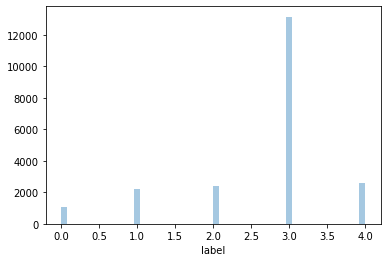

In [17]:
sns.distplot(train["label"], kde=False)

# Preprocess

In [18]:
def get_transforms(*, data):
    if data == "train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [
                A.Resize(config.size, config.size),
                A.CenterCrop(config.size, config.size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

# EDA 2

# 👑 Load Artifacts

In [19]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        # test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [20]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [21]:
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["label"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "label"]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


# Dataset

In [22]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["label"].values
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, label
        return image

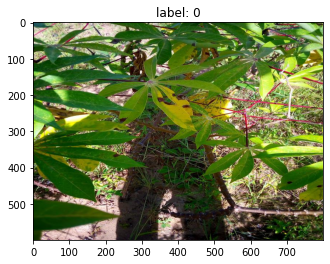

In [23]:
train_ds = BaseDataset(train)
image, label = train_ds[0]
plt.imshow(image)
plt.title(f"label: {label}")
plt.show()

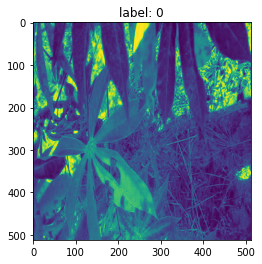

In [24]:
train_ds = BaseDataset(train, transform=get_transforms(data="train"))
image, label = train_ds[0]
plt.imshow(image[0])
plt.title(f"label: {label}")
plt.show()

# 🚗 Model

In [25]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("tf_efficientnet"):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("vit_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
if config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, label in train_loader:
        output = model(image)
        print(output)
        break

BaseModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
        )
        (2): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(24, eps=0.001, momentum=0.1, affin

# Optimizer

# Loss

# Scoring

In [27]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [28]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["label"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"CV": score})
    else:
        wandb.log({f"CV_fold{fold}": score})

# Helper functions

In [29]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [30]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1. / norm_type)
    return total_norm

In [31]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with amp.autocast(enabled=Config.amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps
            
        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()
            optimizer.zero_grad()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [32]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        preds.append(y_preds.softmax(1).to("cpu").numpy())
        # preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Postprocess

# 🏃‍♂️ Train loop

In [33]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_folds):
        num_data = len(train_folds)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer, first_cycle_steps=num_steps, max_lr=config.lr, min_lr=config.min_lr, warmup_steps=(num_steps // 10)
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_folds)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["label"].values

        # if config.criterion == "BCEWithLogitsLoss":
        #     preds = 1 / (1 + np.exp(-preds))

        # scoring
        score = get_score(valid_labels, preds.argmax(1))
        # score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s")
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log({
            "epoch": epoch + 1,
            f"loss/train_fold{fold}": avg_loss,
            f"loss/valid_fold{fold}": avg_val_loss,
            f"score/fold{fold}": score,
        })

        if avg_val_loss < best_loss:
            best_score = score
            best_loss = avg_val_loss
            best_preds = preds
            LOGGER.info(f"Epoch {epoch+1} - Save Best Model. score: {best_score:.4f}, loss: {best_loss:.4f}")

            torch.save(
                {"model": model.state_dict(), "preds": preds}, MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth"
            )
            # use artifacts instead
            # wandb.save(MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = best_preds
    valid_folds["preds"] = best_preds.argmax(1)
    # valid_folds["preds"] = best_preds

    return valid_folds, best_score, best_loss

# Main function

In [34]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])
            
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns = ["fold", "score", "loss"])
        run.log({"Fold Result": table})
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type='model')
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)


# 🚀 Run

In [35]:
main()

========== fold: 0 training ==========


Epoch: [1][0/178] Elapsed 0m 28s (remain 83m 7s) Loss: 1.8158 Grad: 8.9072 LR: 0.000100  
Epoch: [1][100/178] Elapsed 1m 29s (remain 1m 8s) Loss: 0.6726 Grad: 2.2657 LR: 0.000099  
Epoch: [1][177/178] Elapsed 2m 15s (remain 0m 0s) Loss: 0.5888 Grad: 1.5988 LR: 0.000098  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 43s) Loss: 0.2913 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3273 


Epoch 1 - avg_train_loss: 0.5888  avg_val_loss: 0.3273  time: 154s
Epoch 1 - Score: 0.8855140186915887
Epoch 1 - Save Best Model. score: 0.8855, loss: 0.3273


Epoch: [2][0/178] Elapsed 0m 3s (remain 8m 59s) Loss: 0.4614 Grad: 1.5683 LR: 0.000098  
Epoch: [2][100/178] Elapsed 1m 1s (remain 0m 47s) Loss: 0.4243 Grad: 1.7628 LR: 0.000094  
Epoch: [2][177/178] Elapsed 1m 46s (remain 0m 0s) Loss: 0.4182 Grad: 1.7123 LR: 0.000091  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 47s) Loss: 0.2871 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3211 


Epoch 2 - avg_train_loss: 0.4182  avg_val_loss: 0.3211  time: 125s
Epoch 2 - Score: 0.8869158878504673
Epoch 2 - Save Best Model. score: 0.8869, loss: 0.3211


Epoch: [3][0/178] Elapsed 0m 3s (remain 8m 52s) Loss: 0.3580 Grad: 1.2867 LR: 0.000091  
Epoch: [3][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.3645 Grad: 1.6724 LR: 0.000085  
Epoch: [3][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3774 Grad: 1.2094 LR: 0.000080  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 56s) Loss: 0.3076 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3087 


Epoch 3 - avg_train_loss: 0.3774  avg_val_loss: 0.3087  time: 128s
Epoch 3 - Score: 0.8939252336448598
Epoch 3 - Save Best Model. score: 0.8939, loss: 0.3087


Epoch: [4][0/178] Elapsed 0m 2s (remain 8m 50s) Loss: 0.3901 Grad: 1.4957 LR: 0.000080  
Epoch: [4][100/178] Elapsed 1m 4s (remain 0m 49s) Loss: 0.3578 Grad: 1.2213 LR: 0.000073  
Epoch: [4][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3519 Grad: 1.1177 LR: 0.000067  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 0s) Loss: 0.2712 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3008 


Epoch 4 - avg_train_loss: 0.3519  avg_val_loss: 0.3008  time: 129s
Epoch 4 - Score: 0.8995327102803738
Epoch 4 - Save Best Model. score: 0.8995, loss: 0.3008


Epoch: [5][0/178] Elapsed 0m 3s (remain 9m 38s) Loss: 0.2991 Grad: 1.3114 LR: 0.000067  
Epoch: [5][100/178] Elapsed 1m 4s (remain 0m 48s) Loss: 0.3273 Grad: 1.4614 LR: 0.000059  
Epoch: [5][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3233 Grad: 1.2149 LR: 0.000053  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 51s) Loss: 0.2793 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3043 


Epoch 5 - avg_train_loss: 0.3233  avg_val_loss: 0.3043  time: 129s
Epoch 5 - Score: 0.8995327102803738


Epoch: [6][0/178] Elapsed 0m 3s (remain 9m 1s) Loss: 0.3197 Grad: 1.5732 LR: 0.000052  
Epoch: [6][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.3035 Grad: 1.8298 LR: 0.000044  
Epoch: [6][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3045 Grad: 1.4759 LR: 0.000038  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 55s) Loss: 0.2859 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3062 


Epoch 6 - avg_train_loss: 0.3045  avg_val_loss: 0.3062  time: 128s
Epoch 6 - Score: 0.8981308411214953


Epoch: [7][0/178] Elapsed 0m 3s (remain 9m 6s) Loss: 0.3781 Grad: 1.8927 LR: 0.000038  
Epoch: [7][100/178] Elapsed 1m 4s (remain 0m 48s) Loss: 0.2782 Grad: 1.3519 LR: 0.000030  
Epoch: [7][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.2830 Grad: 2.1580 LR: 0.000025  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 58s) Loss: 0.3110 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3076 


Epoch 7 - avg_train_loss: 0.2830  avg_val_loss: 0.3076  time: 128s
Epoch 7 - Score: 0.8985981308411215


Epoch: [8][0/178] Elapsed 0m 3s (remain 9m 4s) Loss: 0.2593 Grad: 1.4187 LR: 0.000025  
Epoch: [8][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.2715 Grad: 1.8344 LR: 0.000018  
Epoch: [8][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.2711 Grad: 1.6014 LR: 0.000014  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 48s) Loss: 0.3066 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3106 


Epoch 8 - avg_train_loss: 0.2711  avg_val_loss: 0.3106  time: 129s
Epoch 8 - Score: 0.8978971962616823


Epoch: [9][0/178] Elapsed 0m 3s (remain 8m 56s) Loss: 0.2427 Grad: 1.4051 LR: 0.000014  
Epoch: [9][100/178] Elapsed 1m 5s (remain 0m 49s) Loss: 0.2624 Grad: 1.3409 LR: 0.000010  
Epoch: [9][177/178] Elapsed 1m 52s (remain 0m 0s) Loss: 0.2575 Grad: 1.0478 LR: 0.000007  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 2s) Loss: 0.2927 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3201 


Epoch 9 - avg_train_loss: 0.2575  avg_val_loss: 0.3201  time: 131s
Epoch 9 - Score: 0.8957943925233645


Epoch: [10][0/178] Elapsed 0m 3s (remain 9m 8s) Loss: 0.2197 Grad: 1.5147 LR: 0.000007  
Epoch: [10][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.2446 Grad: 1.7686 LR: 0.000005  
Epoch: [10][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.2487 Grad: 1.9717 LR: 0.000100  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 55s) Loss: 0.3044 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3183 


Epoch 10 - avg_train_loss: 0.2487  avg_val_loss: 0.3183  time: 128s
Epoch 10 - Score: 0.8964953271028038
========== fold: 0 result ==========
Score: 0.89953
========== fold: 1 training ==========


Epoch: [1][0/178] Elapsed 0m 3s (remain 9m 26s) Loss: 1.8596 Grad: 10.4130 LR: 0.000100  
Epoch: [1][100/178] Elapsed 1m 4s (remain 0m 49s) Loss: 0.6757 Grad: 1.9097 LR: 0.000099  
Epoch: [1][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5857 Grad: 1.7350 LR: 0.000098  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 59s) Loss: 0.3965 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3508 


Epoch 1 - avg_train_loss: 0.5857  avg_val_loss: 0.3508  time: 129s
Epoch 1 - Score: 0.8810747663551401
Epoch 1 - Save Best Model. score: 0.8811, loss: 0.3508


Epoch: [2][0/178] Elapsed 0m 3s (remain 8m 57s) Loss: 0.3107 Grad: 1.2940 LR: 0.000098  
Epoch: [2][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.4080 Grad: 1.4723 LR: 0.000094  
Epoch: [2][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.4143 Grad: 1.7615 LR: 0.000091  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 58s) Loss: 0.3069 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3217 


Epoch 2 - avg_train_loss: 0.4143  avg_val_loss: 0.3217  time: 128s
Epoch 2 - Score: 0.891588785046729
Epoch 2 - Save Best Model. score: 0.8916, loss: 0.3217


Epoch: [3][0/178] Elapsed 0m 3s (remain 9m 14s) Loss: 0.4382 Grad: 1.6333 LR: 0.000091  
Epoch: [3][100/178] Elapsed 1m 5s (remain 0m 49s) Loss: 0.3729 Grad: 1.6111 LR: 0.000085  
Epoch: [3][177/178] Elapsed 1m 52s (remain 0m 0s) Loss: 0.3744 Grad: 1.2604 LR: 0.000080  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 1s) Loss: 0.3062 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3144 


Epoch 3 - avg_train_loss: 0.3744  avg_val_loss: 0.3144  time: 130s
Epoch 3 - Score: 0.8920560747663552
Epoch 3 - Save Best Model. score: 0.8921, loss: 0.3144


Epoch: [4][0/178] Elapsed 0m 3s (remain 9m 42s) Loss: 0.5105 Grad: 1.6799 LR: 0.000080  
Epoch: [4][100/178] Elapsed 1m 6s (remain 0m 50s) Loss: 0.3550 Grad: 1.1276 LR: 0.000073  
Epoch: [4][177/178] Elapsed 1m 54s (remain 0m 0s) Loss: 0.3500 Grad: 1.4203 LR: 0.000067  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 56s) Loss: 0.2939 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3126 


Epoch 4 - avg_train_loss: 0.3500  avg_val_loss: 0.3126  time: 133s
Epoch 4 - Score: 0.8960280373831776
Epoch 4 - Save Best Model. score: 0.8960, loss: 0.3126


Epoch: [5][0/178] Elapsed 0m 2s (remain 8m 41s) Loss: 0.3488 Grad: 1.7659 LR: 0.000067  
Epoch: [5][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.3230 Grad: 1.4040 LR: 0.000059  
Epoch: [5][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3254 Grad: 1.7415 LR: 0.000053  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 55s) Loss: 0.2622 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3120 


Epoch 5 - avg_train_loss: 0.3254  avg_val_loss: 0.3120  time: 128s
Epoch 5 - Score: 0.8936915887850467
Epoch 5 - Save Best Model. score: 0.8937, loss: 0.3120


Epoch: [6][0/178] Elapsed 0m 3s (remain 9m 12s) Loss: 0.3871 Grad: 1.7298 LR: 0.000052  
Epoch: [6][100/178] Elapsed 1m 4s (remain 0m 48s) Loss: 0.3079 Grad: 1.6271 LR: 0.000044  
Epoch: [6][177/178] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3043 Grad: 1.6136 LR: 0.000038  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 53s) Loss: 0.2739 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3146 


Epoch 6 - avg_train_loss: 0.3043  avg_val_loss: 0.3146  time: 130s
Epoch 6 - Score: 0.8950934579439253


Epoch: [7][0/178] Elapsed 0m 3s (remain 9m 0s) Loss: 0.2383 Grad: 1.2479 LR: 0.000038  
Epoch: [7][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.2844 Grad: 1.6915 LR: 0.000030  
Epoch: [7][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.2841 Grad: 2.0026 LR: 0.000025  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 51s) Loss: 0.2747 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3173 


Epoch 7 - avg_train_loss: 0.2841  avg_val_loss: 0.3173  time: 128s
Epoch 7 - Score: 0.8929906542056075


Epoch: [8][0/178] Elapsed 0m 3s (remain 9m 19s) Loss: 0.2578 Grad: 1.4069 LR: 0.000025  
Epoch: [8][100/178] Elapsed 1m 7s (remain 0m 51s) Loss: 0.2666 Grad: 1.3897 LR: 0.000018  
Epoch: [8][177/178] Elapsed 1m 55s (remain 0m 0s) Loss: 0.2686 Grad: 1.8023 LR: 0.000014  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 55s) Loss: 0.2678 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3197 


Epoch 8 - avg_train_loss: 0.2686  avg_val_loss: 0.3197  time: 135s
Epoch 8 - Score: 0.8936915887850467


Epoch: [9][0/178] Elapsed 0m 3s (remain 9m 44s) Loss: 0.2174 Grad: 1.3892 LR: 0.000014  
Epoch: [9][100/178] Elapsed 1m 2s (remain 0m 47s) Loss: 0.2575 Grad: 1.3478 LR: 0.000010  
Epoch: [9][177/178] Elapsed 1m 47s (remain 0m 0s) Loss: 0.2563 Grad: 1.6422 LR: 0.000007  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 50s) Loss: 0.2578 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3214 


Epoch 9 - avg_train_loss: 0.2563  avg_val_loss: 0.3214  time: 126s
Epoch 9 - Score: 0.8957943925233645


Epoch: [10][0/178] Elapsed 0m 3s (remain 9m 24s) Loss: 0.2625 Grad: 1.5978 LR: 0.000007  
Epoch: [10][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.2518 Grad: 1.5409 LR: 0.000005  
Epoch: [10][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.2477 Grad: 1.6812 LR: 0.000100  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 4s) Loss: 0.2465 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3204 


Epoch 10 - avg_train_loss: 0.2477  avg_val_loss: 0.3204  time: 129s
Epoch 10 - Score: 0.8946261682242991
========== fold: 1 result ==========
Score: 0.89369
========== fold: 2 training ==========


Epoch: [1][0/178] Elapsed 0m 3s (remain 9m 54s) Loss: 1.5238 Grad: 6.3059 LR: 0.000100  
Epoch: [1][100/178] Elapsed 1m 2s (remain 0m 47s) Loss: 0.6258 Grad: 1.6523 LR: 0.000099  
Epoch: [1][177/178] Elapsed 1m 47s (remain 0m 0s) Loss: 0.5563 Grad: 1.7562 LR: 0.000098  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 1s) Loss: 0.4785 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3898 


Epoch 1 - avg_train_loss: 0.5563  avg_val_loss: 0.3898  time: 126s
Epoch 1 - Score: 0.8616499182051881
Epoch 1 - Save Best Model. score: 0.8616, loss: 0.3898


Epoch: [2][0/178] Elapsed 0m 3s (remain 9m 45s) Loss: 0.3632 Grad: 1.4053 LR: 0.000098  
Epoch: [2][100/178] Elapsed 1m 2s (remain 0m 47s) Loss: 0.4187 Grad: 1.7414 LR: 0.000094  
Epoch: [2][177/178] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4105 Grad: 1.6811 LR: 0.000091  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 11s) Loss: 0.5908 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3648 


Epoch 2 - avg_train_loss: 0.4105  avg_val_loss: 0.3648  time: 127s
Epoch 2 - Score: 0.8712315961673288
Epoch 2 - Save Best Model. score: 0.8712, loss: 0.3648


Epoch: [3][0/178] Elapsed 0m 3s (remain 9m 59s) Loss: 0.3554 Grad: 1.7141 LR: 0.000091  
Epoch: [3][100/178] Elapsed 1m 2s (remain 0m 47s) Loss: 0.3801 Grad: 2.0598 LR: 0.000085  
Epoch: [3][177/178] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3706 Grad: 1.7109 LR: 0.000080  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 9s) Loss: 0.5483 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3550 


Epoch 3 - avg_train_loss: 0.3706  avg_val_loss: 0.3550  time: 127s
Epoch 3 - Score: 0.8847861649918205
Epoch 3 - Save Best Model. score: 0.8848, loss: 0.3550


Epoch: [4][0/178] Elapsed 0m 3s (remain 9m 41s) Loss: 0.3361 Grad: 1.3866 LR: 0.000080  
Epoch: [4][100/178] Elapsed 1m 2s (remain 0m 47s) Loss: 0.3310 Grad: 1.2393 LR: 0.000073  
Epoch: [4][177/178] Elapsed 1m 45s (remain 0m 0s) Loss: 0.3455 Grad: 1.3539 LR: 0.000067  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 6s) Loss: 0.5293 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3645 


Epoch 4 - avg_train_loss: 0.3455  avg_val_loss: 0.3645  time: 124s
Epoch 4 - Score: 0.8789436784295396


Epoch: [5][0/178] Elapsed 0m 3s (remain 10m 7s) Loss: 0.3499 Grad: 1.5115 LR: 0.000067  
Epoch: [5][100/178] Elapsed 1m 5s (remain 0m 50s) Loss: 0.3203 Grad: 1.3785 LR: 0.000059  
Epoch: [5][177/178] Elapsed 1m 54s (remain 0m 0s) Loss: 0.3185 Grad: 1.5782 LR: 0.000053  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 56s) Loss: 0.5747 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3455 


Epoch 5 - avg_train_loss: 0.3185  avg_val_loss: 0.3455  time: 132s
Epoch 5 - Score: 0.8854872633792942
Epoch 5 - Save Best Model. score: 0.8855, loss: 0.3455


Epoch: [6][0/178] Elapsed 0m 3s (remain 9m 40s) Loss: 0.2227 Grad: 1.2933 LR: 0.000052  
Epoch: [6][100/178] Elapsed 1m 4s (remain 0m 49s) Loss: 0.3001 Grad: 1.0839 LR: 0.000044  
Epoch: [6][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3001 Grad: 1.5930 LR: 0.000038  
EVAL: [0/45] Elapsed 0m 3s (remain 2m 12s) Loss: 0.6001 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3525 


Epoch 6 - avg_train_loss: 0.3001  avg_val_loss: 0.3525  time: 129s
Epoch 6 - Score: 0.8875905585417153


Epoch: [7][0/178] Elapsed 0m 3s (remain 9m 39s) Loss: 0.3489 Grad: 1.6649 LR: 0.000038  
Epoch: [7][100/178] Elapsed 1m 6s (remain 0m 50s) Loss: 0.2702 Grad: 1.2524 LR: 0.000030  
Epoch: [7][177/178] Elapsed 1m 54s (remain 0m 0s) Loss: 0.2728 Grad: 1.6822 LR: 0.000025  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 0s) Loss: 0.6719 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3551 


Epoch 7 - avg_train_loss: 0.2728  avg_val_loss: 0.3551  time: 133s
Epoch 7 - Score: 0.8913297499415751


Epoch: [8][0/178] Elapsed 0m 3s (remain 9m 31s) Loss: 0.2656 Grad: 1.7639 LR: 0.000025  
Epoch: [8][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.2580 Grad: 1.6533 LR: 0.000018  
Epoch: [8][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.2583 Grad: 1.3625 LR: 0.000014  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 1s) Loss: 0.6221 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3571 


Epoch 8 - avg_train_loss: 0.2583  avg_val_loss: 0.3571  time: 128s
Epoch 8 - Score: 0.8833839682168731


Epoch: [9][0/178] Elapsed 0m 3s (remain 9m 1s) Loss: 0.2307 Grad: 1.5781 LR: 0.000014  
Epoch: [9][100/178] Elapsed 1m 6s (remain 0m 50s) Loss: 0.2444 Grad: 1.7834 LR: 0.000010  
Epoch: [9][177/178] Elapsed 1m 54s (remain 0m 0s) Loss: 0.2449 Grad: 1.3562 LR: 0.000007  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 2s) Loss: 0.6553 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3574 


Epoch 9 - avg_train_loss: 0.2449  avg_val_loss: 0.3574  time: 133s
Epoch 9 - Score: 0.8857209628417855


Epoch: [10][0/178] Elapsed 0m 3s (remain 9m 51s) Loss: 0.2743 Grad: 2.1423 LR: 0.000007  
Epoch: [10][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.2392 Grad: 1.8044 LR: 0.000005  
Epoch: [10][177/178] Elapsed 1m 48s (remain 0m 0s) Loss: 0.2376 Grad: 1.9496 LR: 0.000100  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 5s) Loss: 0.6797 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3588 


Epoch 10 - avg_train_loss: 0.2376  avg_val_loss: 0.3588  time: 126s
Epoch 10 - Score: 0.8878242580042066
========== fold: 2 result ==========
Score: 0.88549
========== fold: 3 training ==========


Epoch: [1][0/178] Elapsed 0m 3s (remain 9m 38s) Loss: 1.6410 Grad: 8.4246 LR: 0.000100  
Epoch: [1][100/178] Elapsed 1m 4s (remain 0m 49s) Loss: 0.6600 Grad: 1.9839 LR: 0.000099  
Epoch: [1][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5754 Grad: 1.5199 LR: 0.000098  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 52s) Loss: 0.3159 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3779 


Epoch 1 - avg_train_loss: 0.5754  avg_val_loss: 0.3779  time: 129s
Epoch 1 - Score: 0.8738022902547324
Epoch 1 - Save Best Model. score: 0.8738, loss: 0.3779


Epoch: [2][0/178] Elapsed 0m 3s (remain 9m 14s) Loss: 0.3959 Grad: 1.4505 LR: 0.000098  
Epoch: [2][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.4272 Grad: 1.5393 LR: 0.000094  
Epoch: [2][177/178] Elapsed 1m 47s (remain 0m 0s) Loss: 0.4162 Grad: 1.4111 LR: 0.000091  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 57s) Loss: 0.2693 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3550 


Epoch 2 - avg_train_loss: 0.4162  avg_val_loss: 0.3550  time: 126s
Epoch 2 - Score: 0.8805795746669782
Epoch 2 - Save Best Model. score: 0.8806, loss: 0.3550


Epoch: [3][0/178] Elapsed 0m 2s (remain 8m 49s) Loss: 0.3561 Grad: 1.3751 LR: 0.000091  
Epoch: [3][100/178] Elapsed 1m 5s (remain 0m 49s) Loss: 0.3723 Grad: 1.7314 LR: 0.000085  
Epoch: [3][177/178] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3749 Grad: 1.7271 LR: 0.000080  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 49s) Loss: 0.2361 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3317 


Epoch 3 - avg_train_loss: 0.3749  avg_val_loss: 0.3317  time: 130s
Epoch 3 - Score: 0.8899275531666277
Epoch 3 - Save Best Model. score: 0.8899, loss: 0.3317


Epoch: [4][0/178] Elapsed 0m 3s (remain 9m 46s) Loss: 0.2710 Grad: 1.3265 LR: 0.000080  
Epoch: [4][100/178] Elapsed 1m 5s (remain 0m 49s) Loss: 0.3376 Grad: 1.9934 LR: 0.000073  
Epoch: [4][177/178] Elapsed 1m 52s (remain 0m 0s) Loss: 0.3460 Grad: 1.4632 LR: 0.000067  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 6s) Loss: 0.3069 
EVAL: [44/45] Elapsed 0m 19s (remain 0m 0s) Loss: 0.3486 


Epoch 4 - avg_train_loss: 0.3460  avg_val_loss: 0.3486  time: 133s
Epoch 4 - Score: 0.884318766066838


Epoch: [5][0/178] Elapsed 0m 3s (remain 9m 35s) Loss: 0.4049 Grad: 1.5657 LR: 0.000067  
Epoch: [5][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.3229 Grad: 1.4453 LR: 0.000059  
Epoch: [5][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3210 Grad: 2.2476 LR: 0.000053  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 7s) Loss: 0.2454 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3281 


Epoch 5 - avg_train_loss: 0.3210  avg_val_loss: 0.3281  time: 129s
Epoch 5 - Score: 0.8953026408039262
Epoch 5 - Save Best Model. score: 0.8953, loss: 0.3281


Epoch: [6][0/178] Elapsed 0m 3s (remain 10m 7s) Loss: 0.4206 Grad: 1.9240 LR: 0.000052  
Epoch: [6][100/178] Elapsed 1m 4s (remain 0m 49s) Loss: 0.2926 Grad: 1.8529 LR: 0.000044  
Epoch: [6][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.2931 Grad: 1.4569 LR: 0.000038  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 58s) Loss: 0.2883 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3426 


Epoch 6 - avg_train_loss: 0.2931  avg_val_loss: 0.3426  time: 128s
Epoch 6 - Score: 0.8903949520916102


Epoch: [7][0/178] Elapsed 0m 3s (remain 9m 13s) Loss: 0.2164 Grad: 1.4478 LR: 0.000038  
Epoch: [7][100/178] Elapsed 1m 1s (remain 0m 46s) Loss: 0.2877 Grad: 1.4389 LR: 0.000030  
Epoch: [7][177/178] Elapsed 1m 44s (remain 0m 0s) Loss: 0.2795 Grad: 1.4248 LR: 0.000025  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 3s) Loss: 0.3013 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3486 


Epoch 7 - avg_train_loss: 0.2795  avg_val_loss: 0.3486  time: 123s
Epoch 7 - Score: 0.8880579574666978


Epoch: [8][0/178] Elapsed 0m 3s (remain 9m 6s) Loss: 0.2829 Grad: 1.9131 LR: 0.000025  
Epoch: [8][100/178] Elapsed 1m 4s (remain 0m 49s) Loss: 0.2545 Grad: 1.0800 LR: 0.000018  
Epoch: [8][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.2563 Grad: 1.5272 LR: 0.000014  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 52s) Loss: 0.2671 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3460 


Epoch 8 - avg_train_loss: 0.2563  avg_val_loss: 0.3460  time: 129s
Epoch 8 - Score: 0.8908623510165926


Epoch: [9][0/178] Elapsed 0m 3s (remain 9m 3s) Loss: 0.2408 Grad: 1.5305 LR: 0.000014  
Epoch: [9][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.2499 Grad: 1.4988 LR: 0.000010  
Epoch: [9][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.2463 Grad: 1.6657 LR: 0.000007  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 52s) Loss: 0.2864 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3485 


Epoch 9 - avg_train_loss: 0.2463  avg_val_loss: 0.3485  time: 128s
Epoch 9 - Score: 0.8906286515541014


Epoch: [10][0/178] Elapsed 0m 3s (remain 8m 58s) Loss: 0.1877 Grad: 1.2956 LR: 0.000007  
Epoch: [10][100/178] Elapsed 1m 4s (remain 0m 49s) Loss: 0.2347 Grad: 1.3964 LR: 0.000005  
Epoch: [10][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.2361 Grad: 1.6916 LR: 0.000100  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 58s) Loss: 0.2651 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3465 


Epoch 10 - avg_train_loss: 0.2361  avg_val_loss: 0.3465  time: 129s
Epoch 10 - Score: 0.889226454779154
========== fold: 3 result ==========
Score: 0.89530
========== fold: 4 training ==========


Epoch: [1][0/178] Elapsed 0m 3s (remain 9m 50s) Loss: 1.5039 Grad: 6.6465 LR: 0.000100  
Epoch: [1][100/178] Elapsed 1m 7s (remain 0m 51s) Loss: 0.6392 Grad: 1.6094 LR: 0.000099  
Epoch: [1][177/178] Elapsed 1m 53s (remain 0m 0s) Loss: 0.5649 Grad: 1.6827 LR: 0.000098  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 53s) Loss: 0.3376 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3659 


Epoch 1 - avg_train_loss: 0.5649  avg_val_loss: 0.3659  time: 132s
Epoch 1 - Score: 0.8761392848796448
Epoch 1 - Save Best Model. score: 0.8761, loss: 0.3659


Epoch: [2][0/178] Elapsed 0m 3s (remain 8m 59s) Loss: 0.5834 Grad: 2.1581 LR: 0.000098  
Epoch: [2][100/178] Elapsed 1m 2s (remain 0m 47s) Loss: 0.4226 Grad: 1.5635 LR: 0.000094  
Epoch: [2][177/178] Elapsed 1m 46s (remain 0m 0s) Loss: 0.4107 Grad: 1.9464 LR: 0.000091  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 49s) Loss: 0.3223 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3518 


Epoch 2 - avg_train_loss: 0.4107  avg_val_loss: 0.3518  time: 125s
Epoch 2 - Score: 0.8763729843421361
Epoch 2 - Save Best Model. score: 0.8764, loss: 0.3518


Epoch: [3][0/178] Elapsed 0m 3s (remain 9m 24s) Loss: 0.3668 Grad: 1.3804 LR: 0.000091  
Epoch: [3][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.3667 Grad: 1.3474 LR: 0.000085  
Epoch: [3][177/178] Elapsed 1m 48s (remain 0m 0s) Loss: 0.3732 Grad: 1.8401 LR: 0.000080  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 52s) Loss: 0.3118 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3379 


Epoch 3 - avg_train_loss: 0.3732  avg_val_loss: 0.3379  time: 127s
Epoch 3 - Score: 0.8847861649918205
Epoch 3 - Save Best Model. score: 0.8848, loss: 0.3379


Epoch: [4][0/178] Elapsed 0m 3s (remain 9m 19s) Loss: 0.2783 Grad: 1.4708 LR: 0.000080  
Epoch: [4][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.3389 Grad: 1.5195 LR: 0.000073  
Epoch: [4][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3385 Grad: 1.5780 LR: 0.000067  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 59s) Loss: 0.3376 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3473 


Epoch 4 - avg_train_loss: 0.3385  avg_val_loss: 0.3473  time: 128s
Epoch 4 - Score: 0.8840850666043468


Epoch: [5][0/178] Elapsed 0m 2s (remain 8m 50s) Loss: 0.2244 Grad: 1.2265 LR: 0.000067  
Epoch: [5][100/178] Elapsed 1m 5s (remain 0m 49s) Loss: 0.3079 Grad: 1.4541 LR: 0.000059  
Epoch: [5][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3151 Grad: 1.4815 LR: 0.000053  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 53s) Loss: 0.3066 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3444 


Epoch 5 - avg_train_loss: 0.3151  avg_val_loss: 0.3444  time: 129s
Epoch 5 - Score: 0.8845524655293293


Epoch: [6][0/178] Elapsed 0m 2s (remain 8m 49s) Loss: 0.2517 Grad: 1.5251 LR: 0.000052  
Epoch: [6][100/178] Elapsed 1m 3s (remain 0m 48s) Loss: 0.2892 Grad: 1.6832 LR: 0.000044  
Epoch: [6][177/178] Elapsed 1m 49s (remain 0m 0s) Loss: 0.2905 Grad: 1.1151 LR: 0.000038  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 6s) Loss: 0.3906 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3473 


Epoch 6 - avg_train_loss: 0.2905  avg_val_loss: 0.3473  time: 127s
Epoch 6 - Score: 0.8866557606917504


Epoch: [7][0/178] Elapsed 0m 3s (remain 9m 32s) Loss: 0.1896 Grad: 1.3021 LR: 0.000038  
Epoch: [7][100/178] Elapsed 1m 4s (remain 0m 49s) Loss: 0.2748 Grad: 1.5121 LR: 0.000030  
Epoch: [7][177/178] Elapsed 1m 51s (remain 0m 0s) Loss: 0.2735 Grad: 1.7925 LR: 0.000025  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 56s) Loss: 0.3296 
EVAL: [44/45] Elapsed 0m 18s (remain 0m 0s) Loss: 0.3470 


Epoch 7 - avg_train_loss: 0.2735  avg_val_loss: 0.3470  time: 131s
Epoch 7 - Score: 0.8838513671418555


Epoch: [8][0/178] Elapsed 0m 3s (remain 9m 14s) Loss: 0.3090 Grad: 1.8291 LR: 0.000025  
Epoch: [8][100/178] Elapsed 1m 5s (remain 0m 49s) Loss: 0.2577 Grad: 1.3045 LR: 0.000018  
Epoch: [8][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.2563 Grad: 1.6757 LR: 0.000014  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 51s) Loss: 0.3276 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3562 


Epoch 8 - avg_train_loss: 0.2563  avg_val_loss: 0.3562  time: 129s
Epoch 8 - Score: 0.886188361766768


Epoch: [9][0/178] Elapsed 0m 3s (remain 9m 7s) Loss: 0.2952 Grad: 1.5196 LR: 0.000014  
Epoch: [9][100/178] Elapsed 1m 5s (remain 0m 49s) Loss: 0.2522 Grad: 1.8002 LR: 0.000010  
Epoch: [9][177/178] Elapsed 1m 50s (remain 0m 0s) Loss: 0.2490 Grad: 1.4313 LR: 0.000007  
EVAL: [0/45] Elapsed 0m 2s (remain 2m 2s) Loss: 0.3386 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3582 


Epoch 9 - avg_train_loss: 0.2490  avg_val_loss: 0.3582  time: 129s
Epoch 9 - Score: 0.8847861649918205


Epoch: [10][0/178] Elapsed 0m 3s (remain 8m 51s) Loss: 0.2789 Grad: 1.7398 LR: 0.000007  
Epoch: [10][100/178] Elapsed 1m 6s (remain 0m 50s) Loss: 0.2299 Grad: 2.1128 LR: 0.000005  
Epoch: [10][177/178] Elapsed 1m 56s (remain 0m 0s) Loss: 0.2351 Grad: 1.3486 LR: 0.000100  
EVAL: [0/45] Elapsed 0m 2s (remain 1m 57s) Loss: 0.3252 
EVAL: [44/45] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3652 


Epoch 10 - avg_train_loss: 0.2351  avg_val_loss: 0.3652  time: 135s
Epoch 10 - Score: 0.8836176676793643
========== fold: 4 result ==========
Score: 0.88479
========== CV ==========
Score: 0.89176
wandb: Adding directory to artifact (./models)... Done. 1.7s


In [36]:
wandb.finish()

CV,0.89176
CV_fold0,0.89953
CV_fold1,0.89369
CV_fold2,0.88549
CV_fold3,0.8953
CV_fold4,0.88479
epoch,10
loss,0.32485
loss/train_fold0,0.24868
loss/train_fold1,0.24768
loss/train_fold2,0.23762


CV,▁
CV_fold0,▁
CV_fold1,▁
CV_fold2,▁
CV_fold3,▁
CV_fold4,▁
epoch,▁▂▃▃▅▆▆▇▁▂▃▃▅▆▆▇▁▂▃▃▅▆▆▇▁▂▃▃▅▆▆▇▁▂▃▃▅▆▆█
loss,▁
loss/train_fold0,█▄▄▃▃▂▂▁▁▁
loss/train_fold1,█▄▄▃▃▂▂▁▁▁
loss/train_fold2,█▅▄▃▃▂▂▁▁▁
